In [1]:
import os
import sys
sys.path.append(os.path.abspath('.'))
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../run'))

import itertools
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
import typing
import pandas as pd
from tqdm.notebook import tqdm

from torchvision.transforms import functional as F

from IPython.display import display, Markdown

from simple_relational_reasoning.embeddings.stimuli import build_differet_shapes_stimulus_generator, build_split_text_stimulus_generator, build_random_color_stimulus_generator,\
    find_non_empty_indices, EMPTY_TENSOR_PIXEL
from simple_relational_reasoning.embeddings.triplets import QuinnTripletGenerator, ABOVE_BELOW_RELATION, BETWEEN_RELATION
from simple_relational_reasoning.embeddings.visualizations import filter_and_group, DEFAULT_TEXT_KWARGS, save_plot

In [2]:
reference_positions = [(105, 100)]

def plot_generator_examples(generator, ref_pos=reference_positions):
    plt.figure(figsize=(generator.n_target_types * 2.5, 3))

    for i in range(generator.n_target_types):
        x = generator.generate((80, 100 + (i * 20)), ref_pos, target_index=i)
        ax = plt.subplot(1, generator.n_target_types, i +1)
        ax.imshow(x.permute(1, 2, 0).numpy())


    plt.show()

def plot_triplets(triplets):
    n = triplets.shape[0]
    k = triplets.shape[1]

    fig = plt.figure(figsize=(2 * k, 2 * n))
    fig.patch.set_facecolor('white')

    for row in range(n):
        for col in range(k):
            ax = plt.subplot(n, k, (k * row) + col + 1)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.imshow(triplets[row, col].permute(1, 2, 0).numpy())

            if row == 0:
                if col == k - 1:
                    ax.set_title('Different Relation')
                elif col == k - 2:
                    ax.set_title('Same Relation')
                else:
                    ax.set_title(f'Habituation #{col + 1}')

    fig.tight_layout()

    plt.show()

FLIPS = (
    lambda x: x,
    F.hflip,
    F.vflip,
    lambda x: F.hflip(F.vflip(x))
)

FLIP_NAMES = ('None', 'Horizontal', 'Vertical', 'Both')


def plot_flipped_versions(base_images, base_image_names, save_path=None,
    flips=FLIPS, flip_names=FLIP_NAMES, text_kwargs=None):

    if text_kwargs is None:
        text_kwargs = {}
    
    k = len(base_images)
    n = len(flips)

    fig = plt.figure(figsize=(2 * k, 2 * n))
    fig.patch.set_facecolor('white')

    for row in range(n):
        for col in range(k):
            ax = plt.subplot(n, k, (k * row) + col + 1)
            ax.set_xticks([])
            ax.set_yticks([])

            ax.imshow(flips[row](base_images[col]).permute(1, 2, 0).numpy())

            if row == 0:
                ax.set_title(base_image_names[col], **text_kwargs)

            if col == 0:
                ax.set_ylabel(flip_names[row], **text_kwargs)

    fig.tight_layout()

    if save_path is not None:
        save_plot(save_path, should_prefix=False)

    plt.show()


GENERATOR_NAMES = ('color bar', 'split text', 'random colors')


def create_stimulus_generators_and_names(names=GENERATOR_NAMES, seed=None, **kwargs):
    rng = np.random.default_rng(seed if seed is not None else np.random.randint(0, 2**32))

    generators = (
        build_differet_shapes_stimulus_generator(rng=rng, **kwargs), 
        
        build_split_text_stimulus_generator(
            # reference_box_size=10,
            # total_reference_size=(10, 140), n_reference_patches=8,
            # reference_patch_kwargs=dict(ylim=(-70, 70)),
            rng=rng, **kwargs),
        build_random_color_stimulus_generator(rng=rng, **kwargs)
    )
    
    return zip(generators, names)


In [3]:
BASELINE_TRIPLET_KWARGS = dict(n_target_types=2, extra_diagonal_margin=0)
distance_endpoints_dict = {
    (False, False): (30, 80),
    (True, False): (50, 80),
    (True, True): (40, 80),  
}

def parse_above_below_condition(df):
    above_below_types = []

    for _, (relation, two_refs, adjacent_refs) in \
        df.loc[:, ['relation', 'two_reference_objects', 'adjacent_reference_objects']].iterrows():
        a_b_type = None

        if relation == 'above_below':
            if not two_refs:
                a_b_type = 'one_reference'

            elif adjacent_refs:
                a_b_type = 'adjacent_references'

            else:
                a_b_type = 'gapped_references'

        above_below_types.append(a_b_type)

    return df.assign(above_below_type=above_below_types)

In [4]:
generate_data = False

DATA_PATH = 'centroid_sizes.csv'
LIST_COLUMNS = [
    'row_centroids', 'col_centroids', 
    'first_non_empty_row', 'last_non_empty_row', 
    'first_non_empty_col', 'last_non_empty_col'
]
COLUMNS = [
    'relation', 'two_reference_objects', 
    'adjacent_reference_objects', 'n_habituation_stimuli', 
    'rotate_angle', 'stimulus_generator'
] + LIST_COLUMNS
N_examples = 100
ANGLES = [0, 30, 45, 60, 90, 120, 135, 150]

OPTION_SET = (
    (ABOVE_BELOW_RELATION, BETWEEN_RELATION),
    (False, True),
    (False, True),
    [1, 4],
    ANGLES
) 

if generate_data:
    total_options = np.prod([len(v) for v in OPTION_SET])
    option_iter = itertools.product(*OPTION_SET)

    data_rows = []

    for relation, two_reference_objects, adjacent_reference_objects, n_habituation_stimuli, rotate_angle in tqdm(option_iter, total=total_options):
        if (relation == ABOVE_BELOW_RELATION) and not two_reference_objects and adjacent_reference_objects:
            continue

        if (relation == BETWEEN_RELATION) and ((not two_reference_objects) or adjacent_reference_objects):
            continue

        distance_endpoints = distance_endpoints_dict[(two_reference_objects, adjacent_reference_objects)]

        for stimulus_generator, generator_name in create_stimulus_generators_and_names(rotate_angle=rotate_angle):
            triplet_generator = QuinnTripletGenerator(stimulus_generator, distance_endpoints,
                relation=relation, two_reference_objects=two_reference_objects,
                adjacent_reference_objects=adjacent_reference_objects, n_habituation_stimuli=n_habituation_stimuli,
                track_centroids=True,
                **BASELINE_TRIPLET_KWARGS)

            triplets = triplet_generator(N_examples, normalize=False)
            non_empty_tuples = [find_non_empty_indices(t, empty_value=EMPTY_TENSOR_PIXEL, color_axis=0) for t in triplets.view(-1, *triplets.shape[2:])]
            del triplets
            row_centroids, col_centroids = zip(*triplet_generator.stimulus_centroids)
            row_centroids = list(row_centroids)
            col_centroids = list(col_centroids)

            first_non_empty_row, last_non_empty_row, first_non_empty_col, last_non_empty_col = zip(*non_empty_tuples)
            first_non_empty_row = [i.item() for i in first_non_empty_row]
            last_non_empty_row = [i.item() for i in last_non_empty_row]
            first_non_empty_col = [i.item() for i in first_non_empty_col]
            last_non_empty_col = [i.item() for i in last_non_empty_col]
            
            row = [relation, two_reference_objects, adjacent_reference_objects, 
                n_habituation_stimuli, rotate_angle, generator_name, 
                row_centroids, col_centroids, 
                first_non_empty_row, last_non_empty_row, first_non_empty_col, last_non_empty_col
            ]
            data_rows.append(row)

            del triplet_generator
            del stimulus_generator

    
    data_df = pd.DataFrame(data_rows, columns=COLUMNS)
    data_df = parse_above_below_condition(data_df)
    data_df.to_csv(DATA_PATH, index=False)

else:
    data_df = pd.read_csv(DATA_PATH, converters={col: pd.eval for col in LIST_COLUMNS})    
    data_df = data_df.assign(**{col: data_df[col].apply(list) for col in LIST_COLUMNS})
    data_df = data_df.assign(relation_and_type=data_df.above_below_type)
    data_df.relation_and_type[data_df.relation_and_type.isna()] = 'between'
    

data_df.head() 


/var/folders/h9/kzpqpksx6fq00v9d73x5j51c0000gn/T/ipykernel_45471/2658538706.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df.relation_and_type[data_df.relation_and_type.isna()] = 'between'


,relation,two_reference_objects,adjacent_reference_objects,n_habituation_stimuli,rotate_angle,stimulus_generator,row_centroids,col_centroids,first_non_empty_row,last_non_empty_row,first_non_empty_col,last_non_empty_col,above_below_type,relation_and_type
0,above_below,False,False,1,0,color bar,"[105, 162, 58, 120, 163, 83, 87, 57, 116, 138,...","[97, 142, 59, 55, 126, 82, 78, 113, 107, 88, 5...","[100, 100, 62, 157, 157, 132, 24, 24, 53, 115,...","[149, 149, 110, 193, 193, 167, 63, 63, 93, 163...","[47, 47, 47, 92, 92, 92, 9, 9, 9, 5, 5, 5, 76,...","[147, 147, 147, 192, 192, 192, 109, 109, 109, ...",one_reference,one_reference
1,above_below,False,False,1,0,split text,"[107, 145, 76, 117, 146, 92, 96, 76, 114, 129,...","[102, 131, 77, 74, 121, 92, 89, 113, 109, 96, ...","[102, 102, 64, 140, 140, 115, 42, 42, 71, 112,...","[151, 151, 112, 176, 176, 150, 81, 81, 111, 16...","[32, 32, 32, 61, 61, 61, 7, 7, 7, 4, 4, 4, 51,...","[172, 172, 172, 201, 201, 201, 147, 147, 147, ...",one_reference,one_reference
2,above_below,False,False,1,0,random colors,"[105, 162, 58, 120, 163, 83, 87, 57, 116, 138,...","[97, 142, 59, 55, 126, 82, 78, 113, 107, 88, 5...","[100, 100, 62, 157, 157, 132, 24, 24, 53, 115,...","[149, 149, 110, 193, 193, 167, 63, 63, 93, 163...","[47, 47, 47, 92, 92, 92, 9, 9, 9, 5, 5, 5, 76,...","[147, 147, 147, 192, 192, 192, 109, 109, 109, ...",one_reference,one_reference
3,above_below,False,False,1,30,color bar,"[105, 162, 58, 120, 163, 83, 87, 57, 116, 138,...","[97, 142, 59, 55, 126, 82, 78, 113, 107, 88, 5...","[76, 76, 48, 134, 134, 134, 18, 30, 30, 91, 91...","[134, 165, 134, 207, 191, 191, 87, 87, 87, 149...","[52, 52, 52, 96, 96, 96, 13, 6, 13, 10, 10, 10...","[158, 143, 143, 187, 187, 187, 104, 104, 104, ...",one_reference,one_reference
4,above_below,False,False,1,30,split text,"[107, 145, 76, 117, 146, 92, 96, 76, 114, 129,...","[102, 131, 77, 74, 121, 92, 89, 113, 109, 96, ...","[69, 69, 48, 107, 107, 107, 37, 37, 37, 78, 78...","[147, 163, 147, 193, 185, 185, 116, 116, 116, ...","[39, 39, 39, 68, 68, 68, 15, 10, 15, 12, 12, 1...","[165, 165, 165, 194, 194, 194, 141, 141, 141, ...",one_reference,one_reference


In [9]:
DEFAULT_SUBPLOT_ADJUST_PARAMS = dict(top=0.8)
CENTROID_KEYS = ['row_centroids', 'col_centroids']
BOUNDING_BOX_KEYS = [
    'first_non_empty_row', 'last_non_empty_row',
    'first_non_empty_col', 'last_non_empty_col'
]
DEFAULT_VALUE_KEYS = CENTROID_KEYS + BOUNDING_BOX_KEYS
DEFAULT_CANVAS_LEN = 224
DEFAULT_KEY_ORDERS = dict(
    relation_and_type=['one_reference', 'adjacent_references', 'gapped_references', 'between'],
    above_below_type=['one_reference', 'adjacent_references', 'gapped_references'],
)


def plot_histograms(
    ax: matplotlib.axes.Axes,
    values: pd.core.groupby.SeriesGroupBy,
    ):   
    ax.hist(values.row_centroids, bins=20, alpha=0.5, label='row centroids')
    ax.hist(values.col_centroids, bins=20, alpha=0.5, label='col centroids')


def plot_scatter(ax: matplotlib.axes.Axes,
    values: pd.core.groupby.SeriesGroupBy,
    ):   
    ax.scatter(values.col_centroids, values.row_centroids)


def plot_density(ax: matplotlib.axes.Axes,
    values: pd.core.groupby.SeriesGroupBy,
    ):  
    data = np.stack([values.col_centroids, values.row_centroids])
    density = stats.gaussian_kde(data)

    xmin, ymin = data.min(axis=1)
    xmax, ymax = data.max(axis=1)
    xi, yi = np.mgrid[xmin:xmax:50j, ymin:ymax:50j]

    # Evaluate the KDE on a regular grid...
    coords = np.vstack([item.ravel() for item in [xi, yi]])
    density_samples = density(coords).reshape(xi.shape)
    ax.contourf(xi, yi, density_samples)


def plot_endpoints_density(ax: matplotlib.axes.Axes,
    values: pd.core.groupby.SeriesGroupBy,
    canvas_r: int = DEFAULT_CANVAS_LEN,
    canvas_c: int = DEFAULT_CANVAS_LEN,
    ): 
    canvas = np.zeros((canvas_r, canvas_c))
    for row_start, row_end, col_start, col_end in zip(*[values[key] for key in BOUNDING_BOX_KEYS]):
        canvas[row_start:row_end, col_start:col_end] += 1

    vmax = len(values.first_non_empty_row)
    ax.imshow(canvas, vmin=0, vmax=vmax)


def plot_endpoints_patches(ax: matplotlib.axes.Axes,
    values: pd.core.groupby.SeriesGroupBy,
    canvas_r: int = DEFAULT_CANVAS_LEN,
    canvas_c: int = DEFAULT_CANVAS_LEN,
    ): 
    # patches = []
    ax.invert_yaxis()
    for row_start, row_end, col_start, col_end in zip(*[values[key] for key in BOUNDING_BOX_KEYS]):
        # xy is the bottom corner of the rectangle
        # patches.append()

        ax.add_patch(matplotlib.patches.Rectangle((col_start, row_start),
            col_end - col_start, row_end - row_start, alpha=0.05, color='blue', ls='-'))
    
    ax.set_xlim(0, canvas_c)
    ax.set_ylim(0, canvas_r)


def plot_centroids(df: pd.DataFrame, *, 
    filter_dict: typing.Dict[str, typing.Union[str, typing.Sequence[str]]],
    group_by = typing.Union[str, typing.Sequence[str]],
    single_plot_function: typing.Callable[[matplotlib.axes.Axes, pd.core.groupby.SeriesGroupBy], None] = plot_histograms,
    value_keys: typing.List[str] = DEFAULT_VALUE_KEYS,
    key_orders: typing.Dict[str, typing.Sequence[str]] = DEFAULT_KEY_ORDERS,
    figsize: typing.Tuple[float, float] = None,
    sup_title: typing.Optional[str] = None,
    text_kwargs: typing.Dict[str, str] = DEFAULT_TEXT_KWARGS,
    title_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = None,
    # plot saving arguments
    save_path: typing.Optional[str] = None, 
    subplot_adjust_params: typing.Dict[str, typing.Any] = DEFAULT_SUBPLOT_ADJUST_PARAMS,
    save_should_print: bool = False, 
    ):
    if isinstance(group_by, str):
        group_by = [group_by]

    if len(group_by) > 2:
        raise ValueError('Only up to two group_by keys are supported')

    if title_kwargs is None:
        title_kwargs = {}
    if 'fontsize' not in title_kwargs:
        title_kwargs['fontsize'] = text_kwargs['fontsize'] + 8

    grouped_df = filter_and_group(df, filter_dict, group_by)
    aggregated_df = grouped_df[value_keys].aggregate(sum)

    group_by_keys = {gb: key_orders[gb] if gb in key_orders else    
        list(aggregated_df.index.unique(level=gb)) 
        for gb in group_by}

    if len(group_by) == 1:
        layout = (1, len(group_by_keys[group_by[0]]))

    else:
        layout = (len(group_by_keys[group_by[0]]), len(group_by_keys[group_by[1]]))

    if figsize is None:
        figsize = (layout[1] * 3, layout[0] * 3)

    fig, axes = plt.subplots(*layout, figsize=figsize)
    fig.patch.set_facecolor('white')
    axes = axes.flatten()

    for index, current_group_keys in enumerate(itertools.product(*[group_by_keys[gb] for gb in group_by_keys])):
        ax = axes[index]
        group_values = aggregated_df.loc[current_group_keys]
        single_plot_function(ax, group_values)

        if index < layout[1]:
            ax.set_title(current_group_keys[-1], **text_kwargs)

        if layout[0] > 1 and (index % layout[1] == 0):
            ax.set_ylabel(current_group_keys[0], **text_kwargs)

    # TODO: legends, etc.

    if sup_title is not None:
        plt.suptitle(sup_title, **title_kwargs)
        fig.subplots_adjust(**subplot_adjust_params)

    # TODO: consider if we want to do the above-bar text things again
    if save_path is not None:
        save_plot(save_path, should_print=save_should_print)



In [ ]:

plot_centroids(data_df,
    filter_dict=dict(n_habituation_stimuli=1),
    group_by=['relation_and_type', 'rotate_angle'],
    single_plot_function=plot_endpoints_patches
)

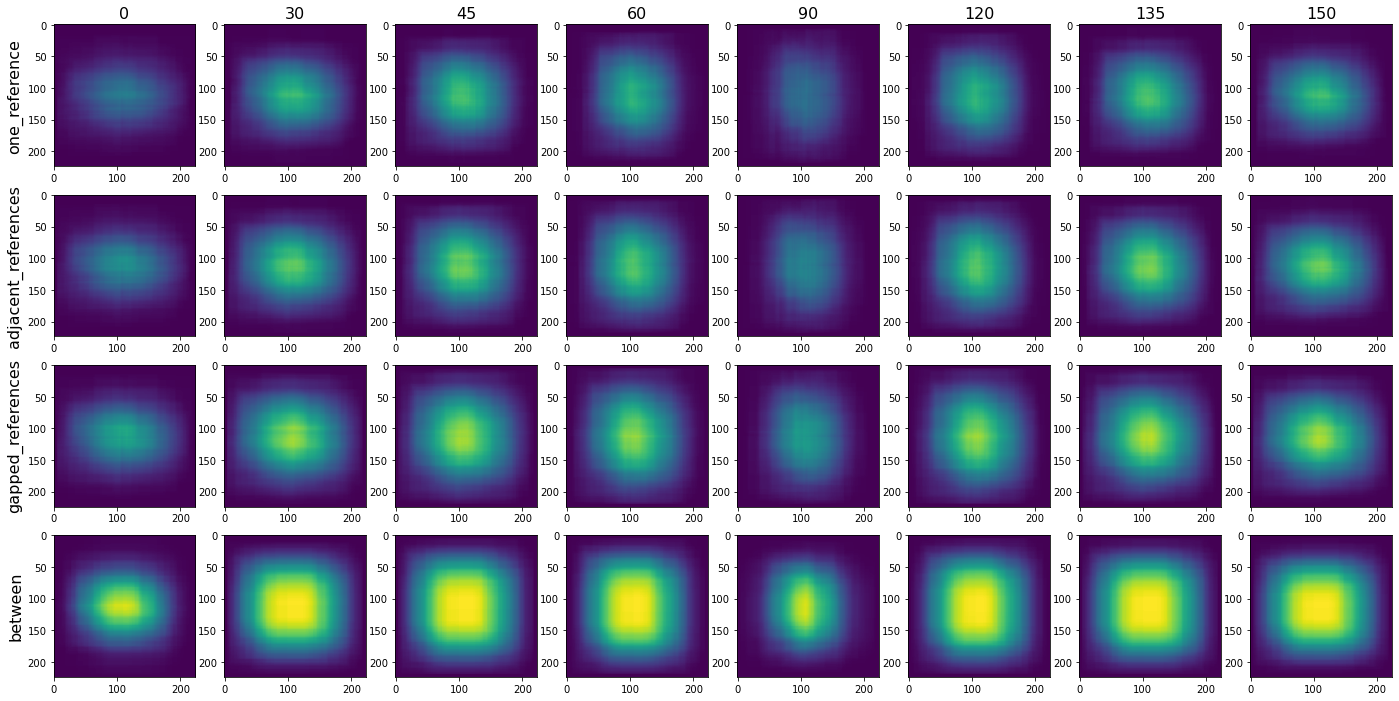

In [10]:
plot_centroids(data_df,
    filter_dict=dict(n_habituation_stimuli=1),
    group_by=['relation_and_type', 'rotate_angle'],
    single_plot_function=plot_endpoints_density,
    save_path='endpoint_density_by_relation_and_angle.png'
)

In [27]:
data_df.relation_and_type.value_counts()

one_reference          48
gapped_references      48
adjacent_references    48
between                48
Name: relation_and_type, dtype: int64

In [50]:
def foo(s):
    print(s)
    print([a.shape for a in s])
    np.concatenate
    
aggregated_df = grouped_df[['row_centroids', 'col_centroids']].aggregate(sum)

In [20]:
ast.literal_eval('(105, 200)')

(105, 200)

In [31]:
grouped_df.row_centroids

In [51]:
aggregated_df

row_centroids  \
two_reference_objects adjacent_reference_objects rotate_angle                                                      
False                 False                      0             [105, 162, 58, 120, 163, 83, 87, 57, 116, 138,...   
                                                 30            [105, 162, 58, 120, 163, 83, 87, 57, 116, 138,...   
                                                 45            [105, 162, 58, 120, 163, 83, 87, 57, 116, 138,...   
                                                 60            [105, 162, 58, 120, 163, 83, 87, 57, 116, 138,...   
                                                 90            [105, 162, 58, 120, 163, 83, 87, 57, 116, 138,...   
                                                 120           [105, 162, 58, 120, 163, 83, 87, 57, 116, 138,...   
                                                 135           [105, 162, 58, 120, 163, 83, 87, 57, 116, 138,...   
                                                 150           [105, 162, 58, 120, 163, 83, 87, 57, 116, 138,...   
True                  False                      0             [105, 162, 58, 120, 163, 83, 87, 57, 116, 138,...   
                                                 30            [105, 162, 58, 120, 163, 83, 87, 57, 116, 138,...   
                                                 45            [105, 162, 58, 120, 163, 83, 87, 57, 116, 138,...   
                                                 60            [105, 162, 58, 120, 163, 83, 87, 57, 116, 138,...   
                                                 90            [105, 162, 58, 120, 163, 83, 87, 57, 116, 138,...   
                                                 120           [105, 162, 58, 120, 163, 83, 87, 57, 116, 138,...   
                                                 135           [105, 162, 58, 120, 163, 83, 87, 57, 116, 138,...   
                                                 150           [105, 162, 58, 120, 163, 83, 87, 57, 116, 138,...   
                      True                       0             [105, 162, 58, 120, 163, 83, 87, 57, 116, 138,...   
                                                 30            [105, 162, 58, 120, 163, 83, 87, 57, 116, 138,...   
                                                 45            [105, 162, 58, 120, 163, 83, 87, 57, 116, 138,...   
                                                 60            [105, 162, 58, 120, 163, 83, 87, 57, 116, 138,...   
                                                 90            [105, 162, 58, 120, 163, 83, 87, 57, 116, 138,...   
                                                 120           [105, 162, 58, 120, 163, 83, 87, 57, 116, 138,...   
                                                 135           [105, 162, 58, 120, 163, 83, 87, 57, 116, 138,...   
                                                 150           [105, 162, 58, 120, 163, 83, 87, 57, 116, 138,...   

                                                                                                   col_centroids  
two_reference_objects adjacent_reference_objects rotate_angle                                                     
False                 False                      0             [97, 142, 59, 55, 126, 82, 78, 113, 107, 88, 5...  
                                                 30            [97, 142, 59, 55, 126, 82, 78, 113, 107, 88, 5...  
                                                 45            [97, 142, 59, 55, 126, 82, 78, 113, 107, 88, 5...  
                                                 60            [97, 142, 59, 55, 126, 82, 78, 113, 107, 88, 5...  
                                                 90            [97, 142, 59, 55, 126, 82, 78, 113, 107, 88, 5...  
                                                 120           [97, 142, 59, 55, 126, 82, 78, 113, 107, 88, 5...  
                                                 135           [97, 142, 59, 55, 126, 82, 78, 113, 107, 88, 5...  
                                               